In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import kmedoids
import adspy_shared_utilities
from adspy_shared_utilities import plot_labelled_scatter
from adjustText import adjust_text


Load the preprocessed cluster dataframe

In [2]:
cluster_df = pd.read_csv('cluster_df')
cluster_df.columns

Index(['Unnamed: 0', 'year', 'gameid', 'season_id', 'id_x', 'name', 'id_y',
       'game_id', 'team_id', 'player_id', 'position', 'player_name', 'goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves', 'created_at',
       'updated_at'],
      dtype='object')

Create new df filtered on the first year represented

In [3]:
year1_df = cluster_df[cluster_df['year'] == 2023]
year1_df = year1_df[['position', 'goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves']]
year1_df.head()


,position,goals,assists,points,shots,shots_on_goal,man_up_goals,man_down_goals,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves
203375,D,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0
203376,A,0,1,1,6,3,0,0,1,0,0,0,0,0,0,0,0,0
203377,D,2,1,3,2,2,0,0,4,2,0,0,0,1,30,0,0,0
203378,A,2,1,3,2,2,1,0,4,4,0,0,0,0,0,0,0,0
203379,M,1,1,2,3,2,0,0,0,1,0,0,0,4,150,0,0,0


In [4]:
year1_df_no = year1_df.dropna()

In [5]:
year1_df.shape, year1_df_no.shape

((164715, 18), (22026, 18))

Create X and y from year1_df for training, sampling, testing, etc.

In [6]:
X_2015 = year1_df_no[['goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves']]
y_2015 = year1_df_no[['position']]

Determine the best k value for KMeans evaluation
Use low Davies Bouldin score and high Calinski Harabasz

In [7]:
davbou = []
calhar = []
inertia = []
kays = range(2,16)  
for k in kays:
    km = KMeans(n_clusters=k, init='random', max_iter=100, n_init=10, random_state=42)
    km.fit(X_2015)
    davbou.append((k, metrics.davies_bouldin_score(X_2015, km.labels_)))
    calhar.append((k, metrics.calinski_harabasz_score(X_2015, km.labels_)))
    inertia.append(km.inertia_)
#print('davbou= ', davbou)
#print('calhar= ', calhar)

In [8]:
print('davbou= ', sorted(davbou, key=lambda a: a[1]))
print('calhar= ', sorted(calhar, key=lambda a: a[1], reverse=True))
print(inertia)

davbou=  [(2, 0.1416622467831058), (3, 0.2365145047557615), (5, 0.33516464835553367), (4, 0.4369162745050782), (7, 0.46017403988934086), (8, 0.5150341230085994), (6, 0.5359929403127618), (9, 0.5445627695124252), (10, 0.6096824922433134), (12, 0.6399242672255856), (11, 0.7011646339692846), (14, 0.7096005643849372), (13, 0.755400492017696), (15, 0.8021889150746241)]
calhar=  [(5, 1957380.6928290548), (11, 1795331.1198286768), (10, 1699653.60999347), (12, 1647069.319620185), (7, 1609386.1659566408), (9, 1440144.5218990946), (8, 1401813.5702991106), (14, 1346162.2637672364), (15, 1327663.1880598462), (13, 1286974.632881853), (4, 1086532.636462719), (3, 1062143.5800598182), (6, 730215.0421727402), (2, 537000.6473872025)]
[1052574194.276558, 274139409.9279208, 179291029.3010002, 74932367.94949755, 160166839.15979666, 60783313.69453846, 59814111.1343339, 50960300.20625529, 38397093.88061545, 32721311.41062409, 32423116.505206622, 38027482.10038206, 33563172.286387786, 31600807.69297377]


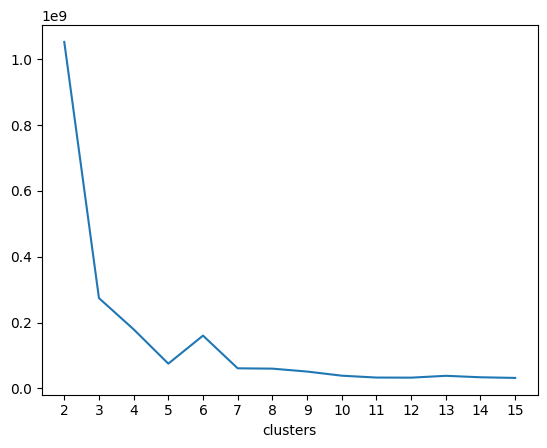

In [9]:
plt.plot(range(2, 16), inertia)
plt.xticks(range(2,16))
plt.xlabel('clusters')
plt.show()

For 2023, 5 clusters is the first match

Normalize the sample data two different ways to see which makes the most sense to use

In [10]:
#X_drop = X.dropna()
X_norm = StandardScaler().fit_transform(X_2015)
X_minmax = MinMaxScaler().fit_transform(X_2015)

In [11]:
print(X_2015.values[1])
print(X_norm[1])
print(X_minmax[1])

[0 1 1 6 3 0 0 1 0 0 0 0 0 0 0 0 0]
[-0.60080857  0.61208478 -0.1178898   1.05000433  0.69088336 -0.26026239
 -0.0574384  -0.38971186 -0.83865773 -0.57589054 -0.16693127 -0.18535611
 -0.40086533 -0.3661837  -0.37216651 -0.33871323 -0.34556201]
[0.         0.09090909 0.07692308 0.25       0.2        0.
 0.         0.04545455 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


I think StandardScaler looks the most reasonable.

Plot a dendrogram of just the scaled data using the ward model

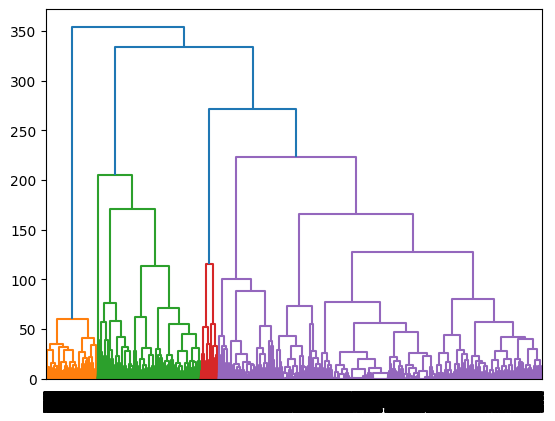

In [12]:
plt.figure()
dendrogram(ward(X_norm))
plt.show()

Run KMeans with the best k from previous analysis

In [13]:
#5 clusters
km5 = KMeans(n_clusters=5, init='random', max_iter=100, n_init=10, random_state=42)
km5.fit(X_norm)
#km5_label = km5.fit_predict(X_minmax)
#km5_label = km5.labels_

KMeans(init='random', max_iter=100, n_clusters=5, n_init=10, random_state=42)

In [14]:
#np.unique(km5_label)
km5.labels_[:20], len(km5.labels_), km5.n_features_in_, km5.cluster_centers_

(array([1, 1, 3, 2, 3, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1]),
 22026,
 17,
 array([[-0.5974906 , -0.45934972, -0.64892842, -0.74752285, -0.70087618,
         -0.26026239, -0.0574384 ,  0.23908727, -0.14456199, -0.28731271,
         -0.16619727, -0.18423511, -0.35821047, -0.32523741,  2.68102526,
          2.49244085,  2.552573  ],
        [-0.39380143, -0.26018996, -0.4065149 , -0.34475779, -0.37996945,
         -0.22627573, -0.04854683, -0.15460129, -0.15059174,  0.07983589,
         -0.14507649, -0.14283955, -0.40009758, -0.3661837 , -0.33903223,
         -0.32063743, -0.3290913 ],
        [ 1.39743804,  0.96636021,  1.46398563,  1.37411094,  1.43176504,
          0.74290152,  0.15693304, -0.11272958,  0.44842214, -0.22167036,
         -0.16409974, -0.18190669, -0.14934675, -0.17320874, -0.37216651,
         -0.33871323, -0.34556201],
        [-0.3865391 , -0.27020922, -0.40639448, -0.38697937, -0.39923393,
         -0.19326239, -0.03990989,  0.07120171, -0.09199794,  0.42941

In [15]:
km5label = km5.predict(X_norm)
km5label[:10]

array([1, 1, 3, 2, 3, 1, 1, 2, 1, 0])

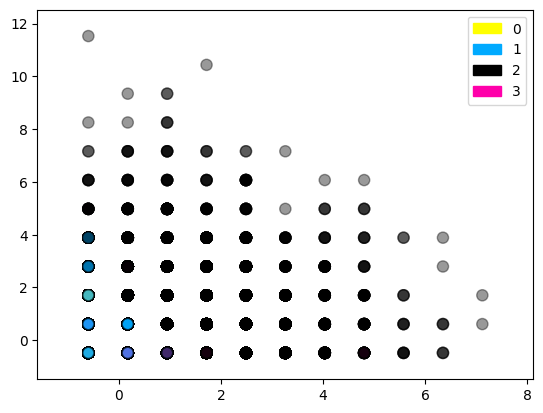

In [16]:
plot_labelled_scatter(X_norm, km5.labels_, [0,1,2,3])

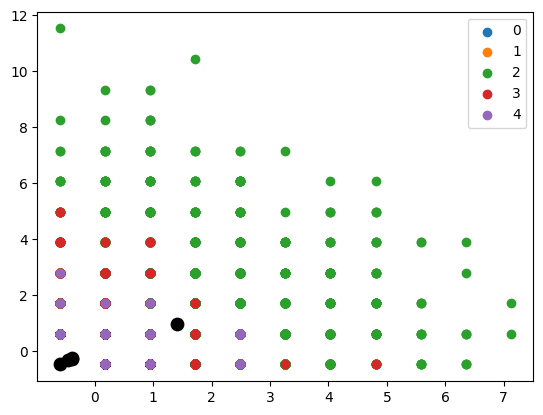

In [17]:

unique_labels = np.unique(km5label)
for i in unique_labels:
    plt.scatter(X_norm[km5label==i, 0], X_norm[km5label==i, 1], label = i)

plt.legend()
plt.scatter(km5.cluster_centers_[:,0], km5.cluster_centers_[:,1], s=80,color='black')
plt.show()

In [18]:
year1_df_no_label = year1_df_no[['position','goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves']]
year1_df_no_label['cluster'] = km5label
year1_df_no_label.head(17)

C:\Users\tpton\AppData\Local\Temp\ipykernel_25280\1554166855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1_df_no_label['cluster'] = km5label


,position,goals,assists,points,shots,shots_on_goal,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,cluster
203375,D,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,1
203376,A,0,1,1,6,3,1,0,0,0,0,0,0,0,0,0,1
203377,D,2,1,3,2,2,4,2,0,0,0,1,30,0,0,0,3
203378,A,2,1,3,2,2,4,4,0,0,0,0,0,0,0,0,2
203379,M,1,1,2,3,2,0,1,0,0,0,4,150,0,0,0,3
203380,A,0,2,2,2,0,1,2,0,0,0,0,0,0,0,0,1
203381,D,1,1,2,2,1,4,0,1,0,0,0,0,0,0,0,1
203382,M,2,2,4,3,3,0,0,0,0,0,0,0,0,0,0,2
203383,M,0,1,1,0,0,1,3,0,0,0,0,0,0,0,0,1
203384,GK,0,0,0,0,0,1,0,0,0,0,0,0,3600,6,16,0


5 clusters makes sense

Time to try PCA on the dataset before the ML algorithm
First need to know the best number of PCs to use

In [19]:
#trying PCA
pca = PCA(17)
Xpca = pca.fit_transform(X_norm)
#Xpca.shape

In [20]:
Xpca[:5]

array([[-1.31990820e+00,  1.25034127e+00, -5.15195120e-01,
        -6.06076330e-01,  2.43446946e+00,  4.33406836e-01,
        -1.00754104e+00,  5.69864158e-01, -1.22285605e-01,
         6.17129510e-01,  2.02925921e-02,  1.43157379e-02,
         2.13309487e-02,  1.27451307e-02,  7.87965597e-03,
         3.60749396e-02,  3.31306336e-12],
       [ 7.41952496e-01, -1.03361785e-01, -3.93184499e-01,
        -8.83480613e-01, -5.69034797e-01, -7.46108547e-02,
         2.92639621e-02,  7.20569974e-01, -3.25886069e-01,
        -2.72674349e-01,  1.33559768e+00,  1.88385177e-02,
         4.34090699e-02, -1.30452295e-03, -5.42815906e-02,
         3.98971821e-02,  6.80566055e-13],
       [ 1.28403621e+00,  7.30792509e-01,  1.92055759e-01,
         1.66254757e+00,  3.40430287e-02, -6.32125603e-01,
         6.86913743e-01,  7.43655382e-02,  8.75531323e-05,
        -1.16937425e+00, -9.98731411e-01,  3.29285073e-02,
        -6.79043339e-01,  2.43303141e-03, -1.02066074e-01,
        -1.28103590e-02,  6.5

In [21]:
var_rat = pca.explained_variance_ratio_
eigenvals = pca.explained_variance_

In [24]:
vals = [v for v in eigenvals if v > 1]
vals

[4.633091076349521,
 2.693574804413837,
 2.150943042045519,
 1.8146695593505118,
 1.1364991459560212,
 1.0021143422427738]

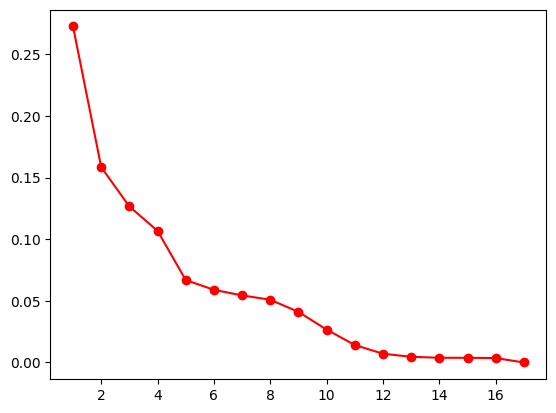

In [22]:
plt.plot(range(1,18), var_rat, 'ro-')
plt.show()

OK. 2 and 3 start the bend even though 5 is where the first big bend is.

Let's confirm with a scree plot of eigenvalues

In [21]:
vary_prop = eigenvals / np.sum(eigenvals)   #proportion of explained variance

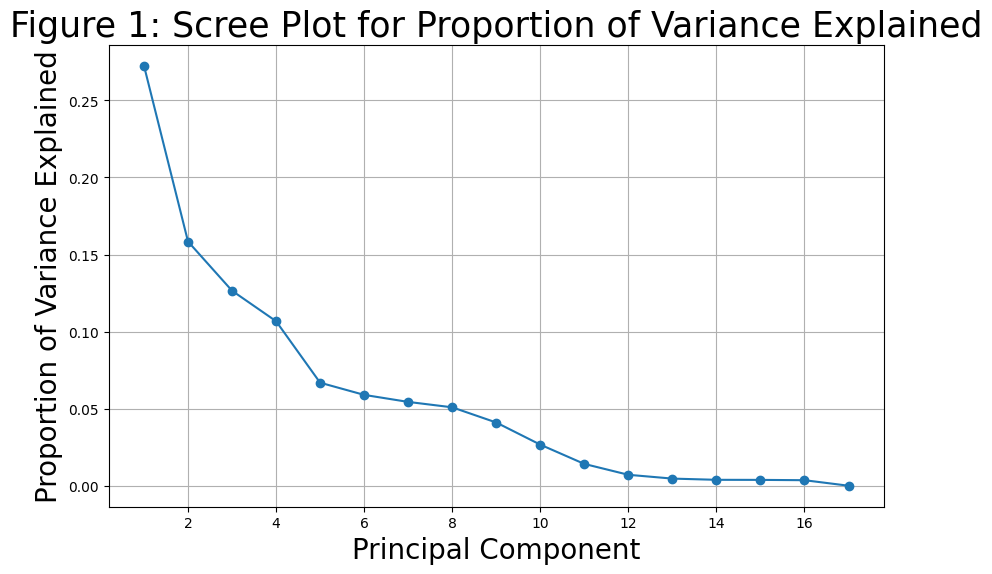

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(vary_prop)+1), vary_prop, marker='o')
plt.xlabel('Principal Component', size = 20)
plt.ylabel('Proportion of Variance Explained', size = 20)
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained', size = 25)
plt.grid(True)

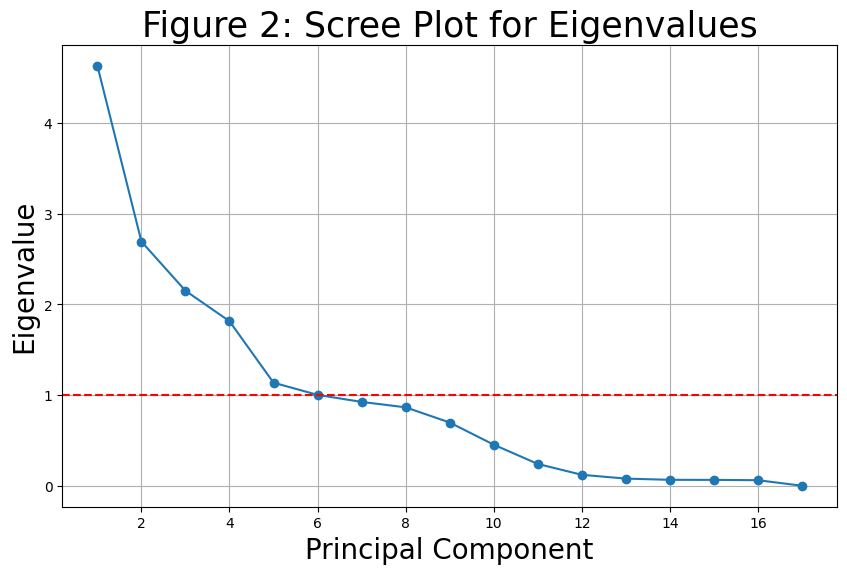

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(eigenvals)+1), eigenvals, marker='o')
plt.xlabel('Principal Component', size = 20)
plt.ylabel('Eigenvalue', size = 20)
plt.title('Figure 2: Scree Plot for Eigenvalues', size = 25)
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)

Confirmed that 5 PCs is the best

In [24]:
pca = PCA(5)
Xpca = pca.fit_transform(X_norm)

In [25]:
Xpca_df = pd.DataFrame(Xpca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
Xpca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.319908,1.250341,-0.515195,-0.606076,2.434469
1,0.741952,-0.103362,-0.393184,-0.883481,-0.569035
2,1.284036,0.730793,0.192055,1.662548,0.034043
3,2.190846,-0.576746,0.973883,0.206218,0.801900
4,0.948630,3.682454,-2.296134,7.722790,-2.951749


In [26]:
#reference site for example and code https://statisticsglobe.com/principal-component-analysis-python
#reference for non overlapping text https://python-graph-gallery.com/web-text-repel-with-matplotlib/

def biplot(score,coeff,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, s=5, color = 'lightblue')
    
    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'red', alpha = 0.5)
        texts.append(plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', 
                 fontsize = 'small', ha = 'center', va = 'center'))
    adjust_text(texts, arrowprops = dict(arrowstyle = '->'))
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
 
    plt.figure()

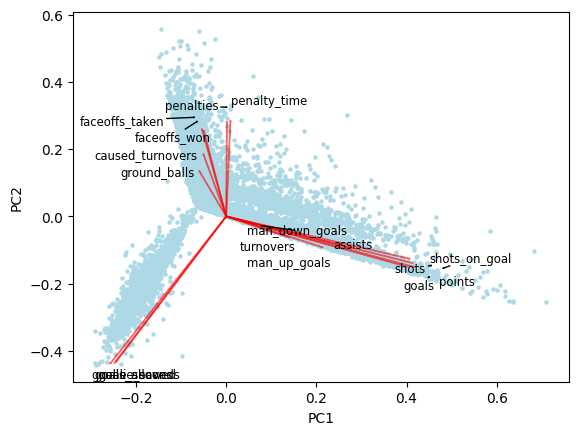

<Figure size 640x480 with 0 Axes>

In [27]:
biplot(Xpca, np.transpose(pca.components_), list(X_2015.columns))

In [28]:
km5.fit(Xpca)

KMeans(n_clusters=5)

In [29]:
label = km5.predict(Xpca)
#label[:20]

In [92]:
label[:25]

array([1, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 2, 4, 4, 4, 4, 1, 3,
       1, 4, 2])

In [93]:
km5.labels_[:22]

array([1, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 2, 4, 4, 4, 4, 1, 3])

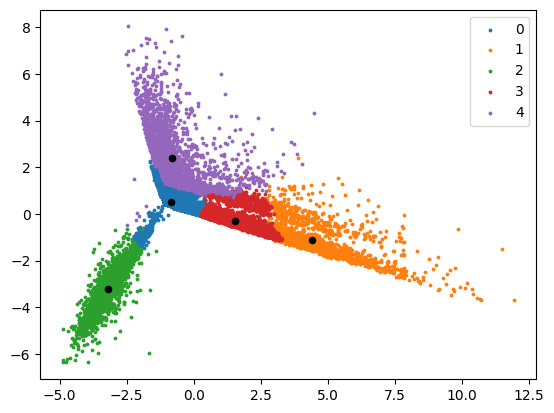

In [30]:
unique_labels = np.unique(label)
for i in unique_labels:
    plt.scatter(Xpca[label==i, 0], Xpca[label==i, 1], s=3, label = i)

plt.legend()
plt.scatter(km5.cluster_centers_[:,0], km5.cluster_centers_[:,1], s=20,color='black')
plt.show()

This looks great.

Aha! This looks a lot better, the clusters don't look that strange. Time to do an analysis to find the best PCA component value and look at other parameters.

In [31]:
pca.components_

array([[ 3.97750118e-01,  2.73240101e-01,  4.15788819e-01,
         4.03879789e-01,  4.10570095e-01,  2.10938668e-01,
         5.97510632e-02, -5.83641291e-02,  1.36119715e-01,
        -4.97417405e-02, -4.89351333e-02, -5.30742676e-02,
         9.39171651e-03,  1.49790622e-03, -2.55611045e-01,
        -2.42345521e-01, -2.46420030e-01],
       [-1.48630492e-01, -9.19042542e-02, -1.50293693e-01,
        -1.25125093e-01, -1.37840246e-01, -9.07959736e-02,
        -2.23728730e-02,  1.32252490e-01, -6.12177431e-02,
         1.82220321e-01,  2.51645352e-01,  2.56854917e-01,
         2.82070730e-01,  2.78825393e-01, -4.35381605e-01,
        -4.29491772e-01, -4.34054701e-01],
       [ 9.63903741e-02,  6.81309773e-02,  1.01714785e-01,
         7.65279462e-02,  8.61795979e-02,  5.88483833e-02,
         3.37862625e-02,  4.34870854e-01,  1.05972027e-01,
        -5.75347795e-02,  5.81362709e-01,  5.61439364e-01,
        -1.25907441e-01, -1.29678258e-01,  1.46321896e-01,
         1.50864695e-01,  1.5

Let's confirm it with mle, which is supposed to output the best # of components

In [32]:
pcamle = PCA(n_components='mle', random_state=42)
Xpcamle = pcamle.fit_transform(X_norm)
labelmle = km5.fit_predict(Xpcamle)

In [102]:
len(pcamle.components_)

16

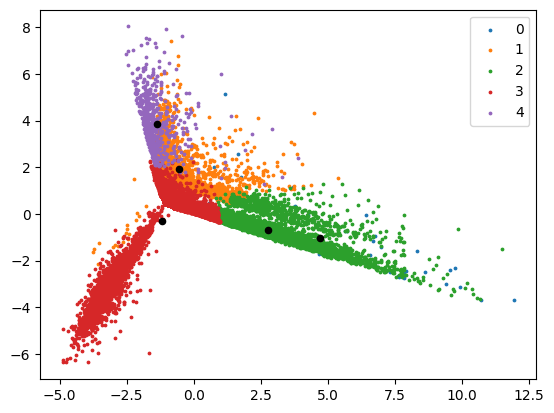

In [33]:
unique_labelsmle = np.unique(labelmle)
for i in unique_labelsmle:
    plt.scatter(Xpcamle[labelmle==i, 0], Xpcamle[labelmle==i, 1], s=3, label = i)
plt.legend()
plt.scatter(km5.cluster_centers_[:,0], km5.cluster_centers_[:,1], s=20,color='black')
plt.show()

Plot magnitude of the features for 5 principal components

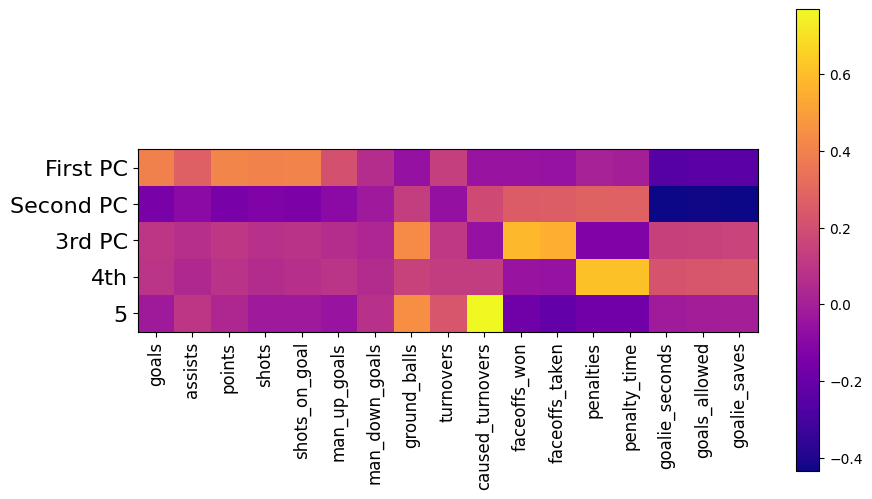

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(pcamle.components_[0:5], interpolation = 'none', cmap = 'plasma')
feature_names=list(X_2015.columns)
plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
plt.yticks(np.arange(0., 5, 1), ['First PC', 'Second PC','3rd PC','4th','5'], fontsize = 16)
plt.colorbar()

Find optimal number of principal components

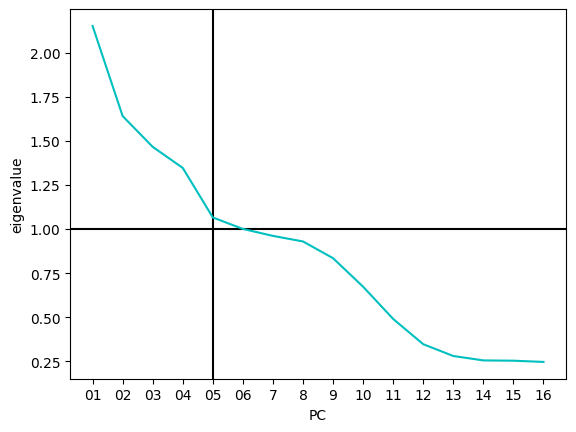

In [35]:

df = pd.DataFrame({'eigenvalue': np.sqrt(pcamle.explained_variance_),
                   'PC':['01','02','03','04','05','06','7','8','9','10','11','12','13','14','15','16']})
plt.axhline(y=1, color='black')
plt.axvline(x=4, color = 'black')
sns.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

Variance plot to do the same as above

0     0.272522
1     0.430961
2     0.557481
3     0.664222
4     0.731071
5     0.790017
6     0.844399
7     0.895274
8     0.936291
9     0.962944
10    0.977088
11    0.984179
12    0.988800
13    0.992634
14    0.996419
15    1.000000
Name: explained var ratio, dtype: float64

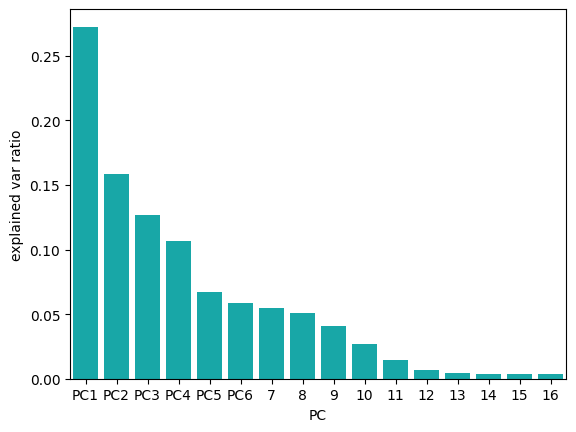

In [36]:
df2 = pd.DataFrame({'explained var ratio':pcamle.explained_variance_ratio_,
                   'PC':['PC1','PC2','PC3','PC4','PC5','PC6','7','8','9','10','11','12','13','14','15','16']})
sns.barplot(x = 'PC',y = "explained var ratio", data = df2, color="c");
np.cumsum(df2['explained var ratio'])

Try sparse pca

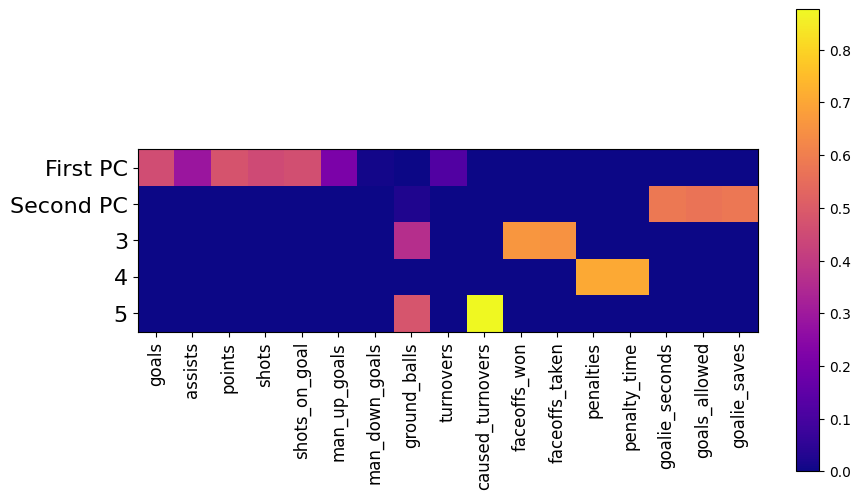

In [37]:
pca_sparse = SparsePCA(n_components=5, alpha=15, random_state=0)
pca_sparse.fit_transform(X_norm)

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(pca_sparse.components_[0:5], interpolation = 'none', cmap = 'plasma')
feature_names=list(X_2015.columns)
plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
plt.yticks(np.arange(0., 5, 1), ['First PC', 'Second PC','3','4','5'], fontsize = 16)
plt.colorbar()